__Tutorial 3: Synaptic transmission - Models of static & dynamic synapses__
***
_(This tutorial requires review)_

Summary:
- Static synapses: communicate the ensemble rate of pre-synaptic neurons (no spiking history dependence per-neuron); e.g., collapsing all the spikes onto a single neurons communicates the same signal
- Dynamic synapses: sensitive to single-neuron interspike intervals

Short-term plasticity in dynamic synapses is not necessarily a learning rule like Hebbian learning. The time scale of excitation/inhibition does not encode long-term memory, but can alter the signal at the receiving end.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

# Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format='retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()


# Plotting Functions

def my_illus_LIFSYN(pars, v_fmp, v):
  """
  Illustartion of FMP and membrane voltage

  Args:
    pars  : parameters dictionary
    v_fmp : free membrane potential, mV
    v     : membrane voltage, mV

  Returns:
    plot of membrane voltage and FMP, alongside with the spiking threshold
    and the mean FMP (dashed lines)
  """

  plt.figure(figsize=(14, 5))
  plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
           label='Free mem. pot.', zorder=2)
  plt.plot(pars['range_t'], v, 'b', lw=1.,
           label='True mem. pot', zorder=1, alpha=0.7)
  plt.axhline(pars['V_th'], 0, 1, color='k', lw=2., ls='--',
              label='Spike Threshold', zorder=1)
  plt.axhline(np.mean(v_fmp), 0, 1, color='r', lw=2., ls='--',
              label='Mean Free Mem. Pot.', zorder=1)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(loc=[1.02, 0.68])
  plt.show()


def my_illus_STD(Poi_or_reg=False, rate=20., U0=0.5,
                 tau_d=100., tau_f=50., plot_out=True):
  """
   Only for one presynaptic train

  Args:
    Poi_or_reg : Poisson or regular input spiking trains
    rate       : Rate of input spikes, Hz
    U0         : synaptic release probability at rest
    tau_d      : synaptic depression time constant of x [ms]
    tau_f      : synaptic facilitation time constantr of u [ms]
    plot_out   : whether ot not to plot, True or False

  Returns:
    Nothing.
  """

  T_simu = 10.0 * 1000 / (1.0 * rate)  # 10 spikes in the time window
  pars = default_pars(T=T_simu)
  dt = pars['dt']

  if Poi_or_reg:
    # Poisson type spike train
    pre_spike_train = Poisson_generator(pars, rate, n=1)
    pre_spike_train = pre_spike_train.sum(axis=0)
  else:
    # Regular firing rate
    isi_num = int((1e3/rate)/dt)  # number of dt
    pre_spike_train = np.zeros(len(pars['range_t']))
    pre_spike_train[::isi_num] = 1.

  u, R, g = dynamic_syn(g_bar=1.2, tau_syn=5., U0=U0,
                        tau_d=tau_d, tau_f=tau_f,
                        pre_spike_train=pre_spike_train,
                        dt=pars['dt'])

  if plot_out:
    plt.figure(figsize=(12, 6))

    plt.subplot(221)
    plt.plot(pars['range_t'], R, 'b', label='R')
    plt.plot(pars['range_t'], u, 'r', label='u')
    plt.legend(loc='best')
    plt.xlim((0, pars['T']))
    plt.ylabel(r'$R$ or $u$ (a.u)')
    plt.subplot(223)
    spT = pre_spike_train > 0
    t_sp = pars['range_t'][spT]  #spike times
    plt.plot(t_sp, 0. * np.ones(len(t_sp)), 'k|', ms=18, markeredgewidth=2)
    plt.xlabel('Time (ms)');
    plt.xlim((0, pars['T']))
    plt.yticks([])
    plt.title('Presynaptic spikes')

    plt.subplot(122)
    plt.plot(pars['range_t'], g, 'r', label='STP synapse')
    plt.xlabel('Time (ms)')
    plt.ylabel('g (nS)')
    plt.xlim((0, pars['T']))

    plt.tight_layout()

  if not Poi_or_reg:
    return g[isi_num], g[9*isi_num]


def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Args:
    pars   : parameter dictionary
    v      : volt trajetory
    sp     : spike train

  Returns:
    figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt = pars['dt']
  if sp.size:
      sp_num = (sp/dt).astype(int) - 1
      v[sp_num] += 10

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--', lw=1.)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')


# Helper Functions

def my_GWN(pars, mu, sig, myseed=False):
  """
  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                  the same seed will give the same random number sequence

  Returns:
    I          : Gaussian White Noise (GWN) input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable. However, when you want to generate multiple realizations
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to seconds.
  I_GWN = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_GWN


def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train


def default_pars(**kwargs):
  pars = {}

  ### typical neuron parameters###
  pars['V_th'] = -55.    # spike threshold [mV]
  pars['V_reset'] = -75. # reset potential [mV]
  pars['tau_m'] = 10.    # membrane time constant [ms]
  pars['g_L'] = 10.      # leak conductance [nS]
  pars['V_init'] = -65.  # initial potential [mV]
  pars['E_L'] = -75.     # leak reversal potential [mV]
  pars['tref'] = 2.      # refractory time (ms)

  ### simulation parameters ###
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  ### external parameters if any ###
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars

(Summarize governing equations for conductance-based synapses). We first modify our LIF Neuron to include conductance-based synapses. This model allows us to consider both excitatory and inhibitory spike trains.

In [2]:
def run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in):
  """
  Conductance-based LIF dynamics

  Args:
    pars               : parameter dictionary
    I_inj              : injected current [pA]. The injected current here
                         can be a value or an array
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    pre_spike_train_in : spike train input from presynaptic inhibitory neuron

  Returns:
    rec_spikes         : spike times
    rec_v              : mebrane potential
    gE                 : postsynaptic excitatory conductance
    gI                 : postsynaptic inhibitory conductance

  """

  # Retrieve parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  gE_bar, gI_bar = pars['gE_bar'], pars['gI_bar']
  VE, VI = pars['VE'], pars['VI']
  tau_syn_E, tau_syn_I = pars['tau_syn_E'], pars['tau_syn_I']
  tref = pars['tref']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  tr = 0.
  v = np.zeros(Lt)
  v[0] = V_init
  gE = np.zeros(Lt)
  gI = np.zeros(Lt)
  Iinj = I_inj * np.ones(Lt)  # ensure Iinj has length Lt

  if pre_spike_train_ex.max() == 0:
    pre_spike_train_ex_total = np.zeros(Lt)
  else:
    pre_spike_train_ex_total = pre_spike_train_ex.sum(axis=0) * np.ones(Lt)

  if pre_spike_train_in.max() == 0:
    pre_spike_train_in_total = np.zeros(Lt)
  else:
    pre_spike_train_in_total = pre_spike_train_in.sum(axis=0) * np.ones(Lt)

  # simulation
  rec_spikes = []  # recording spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # update the synaptic conductance
    gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + gE_bar * pre_spike_train_ex_total[it + 1]
    gI[it + 1] = gI[it] - (dt / tau_syn_I) * gI[it] + gI_bar * pre_spike_train_in_total[it + 1]

    # calculate the increment of the membrane potential
    dv = (dt / tau_m) * (-(v[it] - E_L) \
                         - (gE[it + 1] / g_L) * (v[it] - VE) \
                         - (gI[it + 1] / g_L) * (v[it] - VI) + Iinj[it] / g_L)

    # update membrane potential
    v[it+1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes, gE, gI

Below we demonstrate the new LIF neuron model with Poisson spike trains as input (both excitatory and inhibitory). We also compute the Free Membrane Potential (FMP), which is the membrane potential of the neuron when the spike threshold is removed. Although this is an artificial measure, it gives an idea of the average strength of the input current.

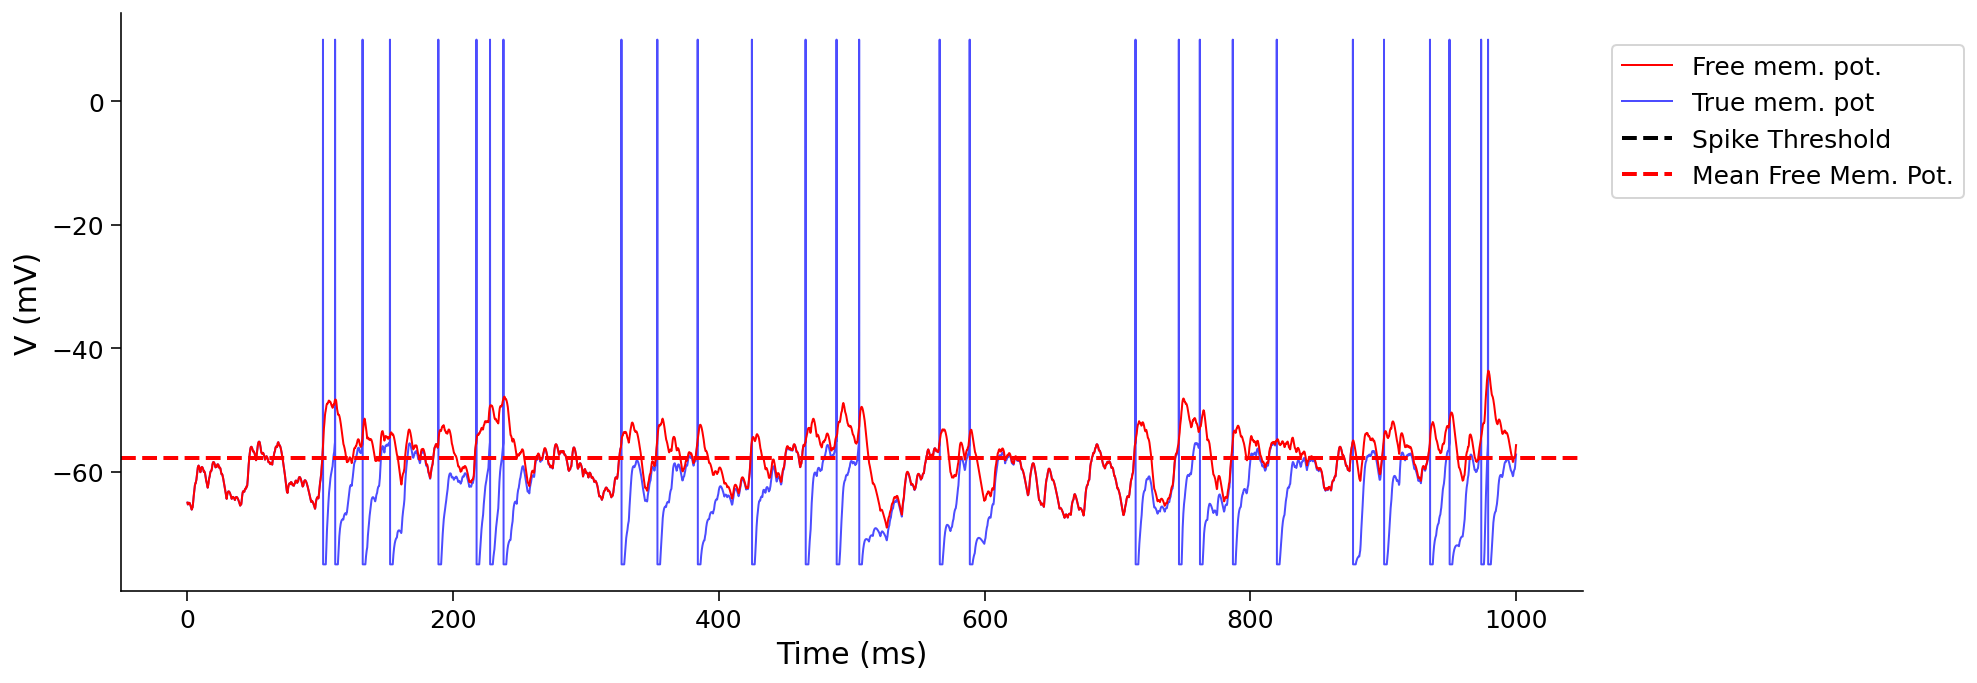

In [7]:
# Get default parameters
pars = default_pars(T=1000.)

# Add parameters
pars['gE_bar'] = 2.4    # [nS]
pars['VE'] = 0.         # [mV] excitatory reversal potential
pars['tau_syn_E'] = 2.  # [ms]
pars['gI_bar'] = 2.4    # [nS]
pars['VI'] = -80.       # [mV] inhibitory reversal potential
pars['tau_syn_I'] = 5.  # [ms]

# Generate presynaptic spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=80)
pre_spike_train_in = Poisson_generator(pars, rate=10, n=20)

# Simulate conductance-based LIF model
v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                     pre_spike_train_in)

# Show spikes more clearly by setting voltage high
dt, range_t = pars['dt'], pars['range_t']
if rec_spikes.size:
  sp_num = (rec_spikes / dt).astype(int) - 1
  v[sp_num] = 10   # draw nicer spikes

# Change the threshold to calculate FMP (prevent resetting of membrane potential)
pars['V_th'] = np.inf

# Calculate FMP
v_fmp, _, _, _ = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

my_illus_LIFSYN(pars, v_fmp, v)

Below we explore how varying the ratio between the excitatory and inhibitory inputs changes the firing rate and the spike time regularity. We see that when the mean free membrane potential is below the spiking threshold, the FMP has large fluctuations, and the ISIs are more irregular. In this case, the distribution of the ISIs is Poisson-like. When the the mean free membran potential is above the spiking threshold, we don't see as much fluctuation in the FMP, so the ISIs are more regular.

In [8]:
my_layout.width = '450px'
@widgets.interact(
    inh_rate=widgets.FloatSlider(20., min=10., max=60., step=5.,
                                 layout=my_layout),
    exc_rate=widgets.FloatSlider(10., min=2., max=20., step=2.,
                                 layout=my_layout)
)


def EI_isi_regularity(exc_rate, inh_rate):

  pars = default_pars(T=1000.)
  # Add parameters
  pars['gE_bar'] = 3.     # [nS]
  pars['VE'] = 0.         # [mV] excitatory reversal potential
  pars['tau_syn_E'] = 2.  # [ms]
  pars['gI_bar'] = 3.     # [nS]
  pars['VI'] = -80.       # [mV] inhibitory reversal potential
  pars['tau_syn_I'] = 5.  # [ms]

  pre_spike_train_ex = Poisson_generator(pars, rate=exc_rate, n=80)
  pre_spike_train_in = Poisson_generator(pars, rate=inh_rate, n=20)  # 4:1

  # Lets first simulate a neuron with identical input but with no spike
  # threshold by setting the threshold to a very high value
  # so that we can look at the free membrane potential
  pars['V_th'] = 1e3
  v_fmp, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                           pre_spike_train_in)

  # Now simulate a LIP with a regular spike threshold
  pars['V_th'] = -55.
  v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                       pre_spike_train_in)
  dt, range_t = pars['dt'], pars['range_t']
  if rec_spikes.size:
      sp_num = (rec_spikes / dt).astype(int) - 1
      v[sp_num] = 10  # draw nicer spikes

  spike_rate = 1e3 * len(rec_spikes) / pars['T']

  cv_isi = 0.
  if len(rec_spikes) > 3:
    isi = np.diff(rec_spikes)
    cv_isi = np.std(isi) / np.mean(isi)

  print('\n')
  plt.figure(figsize=(15, 10))
  plt.subplot(211)
  plt.text(500, -35, f'Spike rate = {spike_rate:.3f} (sp/s), Mean of Free Mem Pot = {np.mean(v_fmp):.3f}',
           fontsize=16, fontweight='bold', horizontalalignment='center',
           verticalalignment='bottom')
  plt.text(500, -38.5, f'CV ISI = {cv_isi:.3f}, STD of Free Mem Pot = {np.std(v_fmp):.3f}',
           fontsize=16, fontweight='bold', horizontalalignment='center',
           verticalalignment='bottom')

  plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
           label='Free mem. pot.', zorder=2)
  plt.plot(pars['range_t'], v, 'b', lw=1.,
           label='mem. pot with spk thr', zorder=1, alpha=0.7)
  plt.axhline(pars['V_th'], 0, 1, color='k', lw=1., ls='--',
              label='Spike Threshold', zorder=1)
  plt.axhline(np.mean(v_fmp),0, 1, color='r', lw=1., ls='--',
              label='Mean Free Mem. Pot.', zorder=1)
  plt.ylim(-76, -39)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(loc=[1.02, 0.68])

  plt.subplot(223)
  plt.plot(pars['range_t'][::3], gE[::3], 'r', lw=1)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_E$ (nS)')

  plt.subplot(224)
  plt.plot(pars['range_t'][::3], gI[::3], 'b', lw=1)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_I$ (nS)')

  plt.tight_layout()

interactive(children=(FloatSlider(value=10.0, description='exc_rate', layout=Layout(width='450px'), max=20.0, …

(summarize differential equations governing dynamic synapses here)

In [9]:
def dynamic_syn(g_bar, tau_syn, U0, tau_d, tau_f, pre_spike_train, dt):
  """
  Short-term synaptic plasticity

  Args:
    g_bar           : synaptic conductance strength
    tau_syn         : synaptic time constant [ms]
    U0              : synaptic release probability at rest
    tau_d           : synaptic depression time constant of x [ms]
    tau_f           : synaptic facilitation time constantr of u [ms]
    pre_spike_train : total spike train (number) input
                      from presynaptic neuron
    dt              : time step [ms]

  Returns:
    u               : usage of releasable neurotransmitter
    R               : fraction of synaptic neurotransmitter resources available
    g               : postsynaptic conductance

  """

  Lt = len(pre_spike_train)
  # Initialize
  u = np.zeros(Lt)
  R = np.zeros(Lt)
  R[0] = 1.
  g = np.zeros(Lt)

  # simulation
  for it in range(Lt - 1):
    # Compute du
    du = -(dt / tau_f) * u[it] + U0 * (1.0 - u[it]) * pre_spike_train[it + 1]
    u[it + 1] = u[it] + du
    # Compute dR
    dR = (dt / tau_d) * (1.0 - R[it]) - u[it + 1] * R[it] * pre_spike_train[it + 1]
    R[it + 1] = R[it] + dR
    # Compute dg
    dg = -(dt / tau_syn) * g[it] + g_bar * R[it] * u[it + 1] * pre_spike_train[it + 1]
    g[it + 1] = g[it] + dg

  return u, R, g

Explore how the synaptic conductance $g$ changes for various rates of incoming Poisson spike trains. Generally, we see that the PSP amplitude depends on the frequency of the spike rate of the presynaptic neuron. 

In [10]:
def my_STD_diff_rate(rate, Poi_or_Reg):
      _ = my_illus_STD(Poi_or_reg=Poi_or_Reg, rate=rate)


_ = widgets.interact(my_STD_diff_rate, rate=(10., 100.1, 5.),
                     Poi_or_Reg=(0, 1, 1))

interactive(children=(FloatSlider(value=55.0, description='rate', max=100.1, min=10.0, step=5.0), IntSlider(va…

Explore short-term synaptic depression with a regular spike train.

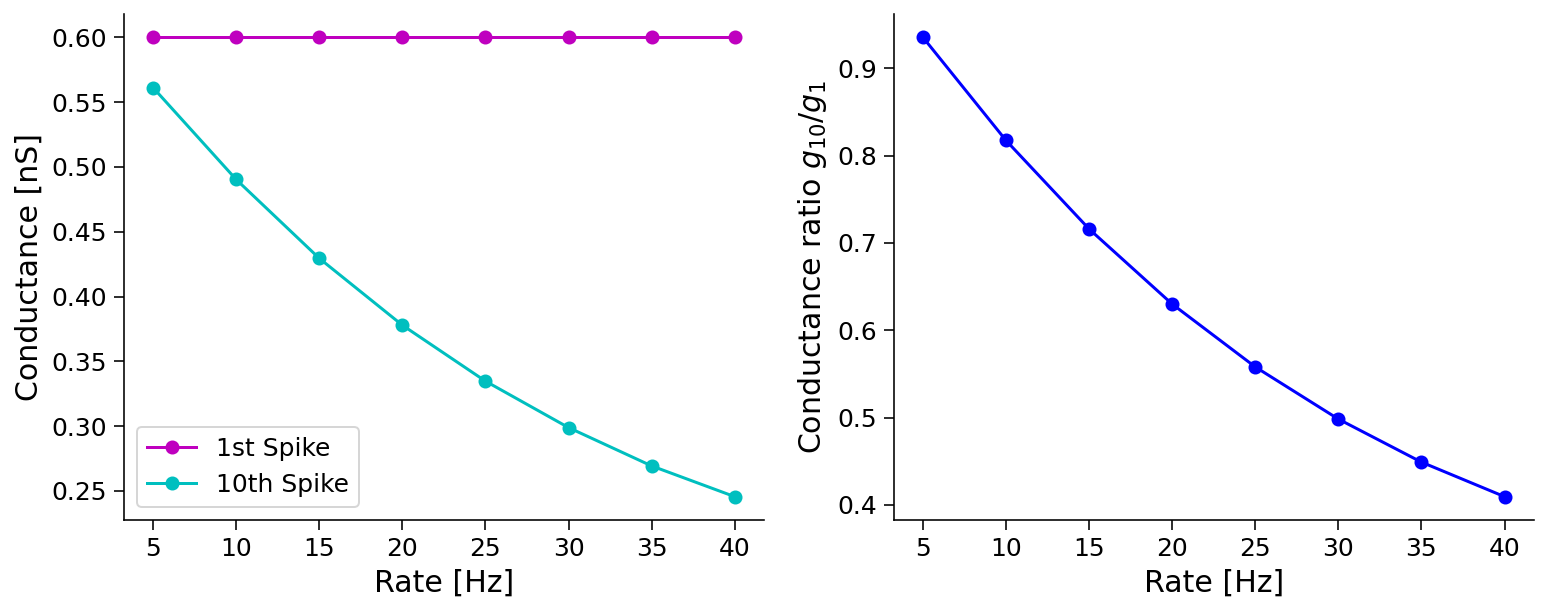

In [11]:
input_rate = np.arange(5., 40.1, 5.)
g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
g_2 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

for ii in range(len(input_rate)):
   g_1[ii], g_2[ii] = my_illus_STD(Poi_or_reg=False, rate=input_rate[ii],
                                   plot_out=False, U0=0.5, tau_d=100., tau_f=50)

plt.figure(figsize=(11, 4.5))

plt.subplot(121)
plt.plot(input_rate, g_1, 'm-o', label='1st Spike')
plt.plot(input_rate, g_2, 'c-o', label='10th Spike')
plt.xlabel('Rate [Hz]')
plt.ylabel('Conductance [nS]')
plt.legend()

plt.subplot(122)
plt.plot(input_rate, g_2 / g_1, 'b-o')
plt.xlabel('Rate [Hz]')
plt.ylabel(r'Conductance ratio $g_{10}/g_{1}$')
plt.tight_layout()

Explore short-term synaptic facilitation with a regular spike train.

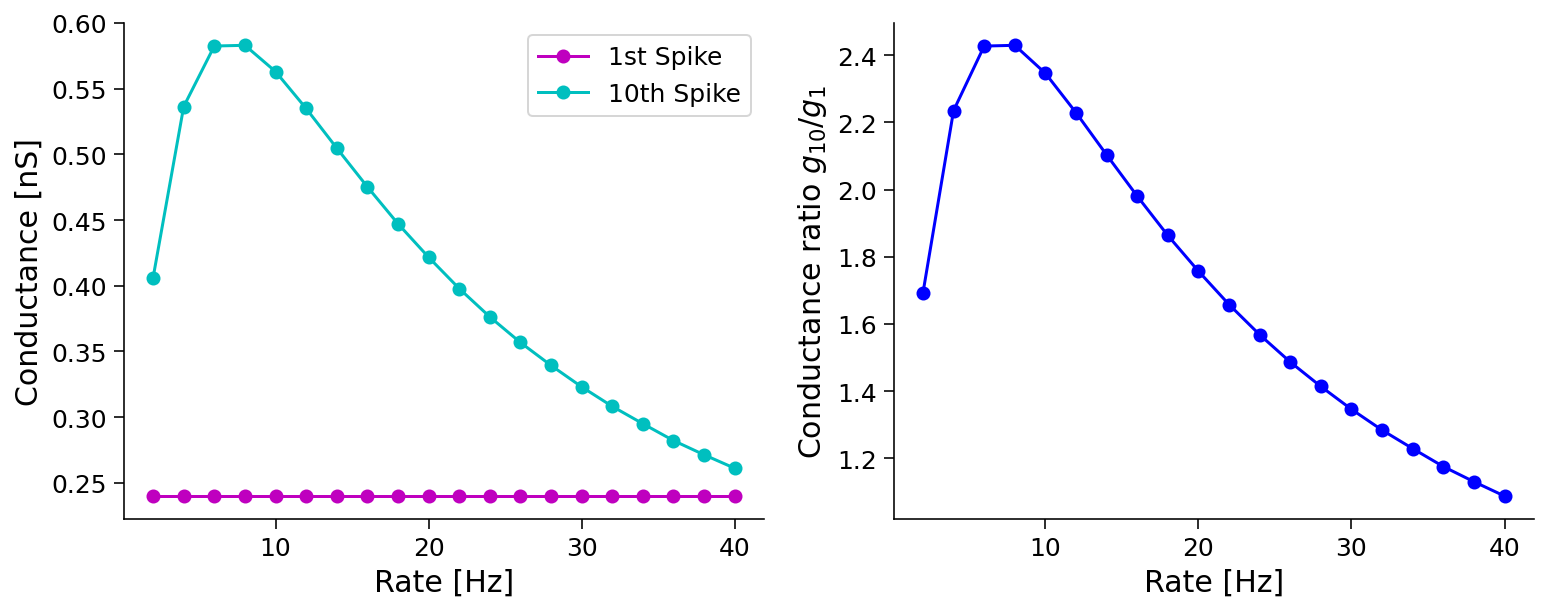

In [12]:
# Regular firing rate
input_rate = np.arange(2., 40.1, 2.)
g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
g_2 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

for ii in range(len(input_rate)):
   g_1[ii], g_2[ii] = my_illus_STD(Poi_or_reg=False, rate=input_rate[ii],
                                   plot_out=False,
                                   U0=0.2, tau_d=100., tau_f=750.)

plt.figure(figsize=(11, 4.5))

plt.subplot(121)
plt.plot(input_rate, g_1, 'm-o', label='1st Spike')
plt.plot(input_rate, g_2, 'c-o', label='10th Spike')
plt.xlabel('Rate [Hz]')
plt.ylabel('Conductance [nS]')
plt.legend()

plt.subplot(122)
plt.plot(input_rate, g_2 / g_1, 'b-o',)
plt.xlabel('Rate [Hz]')
plt.ylabel(r'Conductance ratio $g_{10}/g_{1}$')
plt.tight_layout()